#### project 과정
본 프로젝트는 Transformer 아키텍처를 활용하여 한국어 문맥을 이해하고 응답하는 챗봇 모델을 구현하고, 다양한 하이퍼파라미터 및 전처리 기법을 실험하여 성능을 최적화하는 것을 목표로 합니다.

- 핵심 메커니즘 (Key Components)
    - Positional Encoding: 병렬 처리를 수행하는 Transformer의 특성상 결여되는 위치 정보를 주입하여 모델이 단어의 순서와 맥락을 파악하도록 설계 (정확도: 높음)

    - Scaled Dot Product Attention: 차원이 커짐에 따라 Softmax 값이 극단적으로 치우치는 현상을 방지하기 위해 $\sqrt{d_k}$로 스케일링하여 학습 안정성 확보 (정확도: 높음)

    - Multi-Head Attention: 입력을 여러 개의 헤드로 나누어 병렬적으로 어텐션을 수행함으로써, 문장 내 다양한 관계적 특징을 동시에 포착 (정확도: 높음)

    - Look-Ahead Mask: 디코더 학습 시 미래의 토큰을 참조하지 못하도록 마스킹하여 자기회귀(Autoregressive) 특성 유지 (정확도: 높음)

- 실험 및 최적화 과정 (Experiments)  
    1. 학습 전략 및 최적화 (Optimizer & Scheduler)  
        Adam → AdamW: 가중치 감쇠(Weight Decay)가 학습률에 독립적으로 작용하도록 개선하여 과대적합을 방지하고 일반화 성능 향상

        결과: Accuracy 0.38(Adam) → **0.88(AdamW)**로 비약적 향상 (정확도: 높음)

        Scheduler 개선: 선형 워밍업과 코사인 어닐링의 단점을 보완하기 위해 Cosine Warmup 적용. 초기 학습 안정성과 후반부 수렴 성능을 동시에 확보

    2. 토크나이징 전략 (Tokenization)  
        BPE → Unigram (SentencePiece): 빈도 기반의 BPE 대신 확률 기반의 Unigram 방식을 채택하여 정보량이 풍부한 서브워드 단위로 분절

        결과: 정량적 지표(Acc)는 유사하나, 정성적 테스트 결과 Unigram 모델이 더 다양한 답변을 생성함 (정확도: 중간 - 테스트 표본에 의존적)

    3. 데이터 증강 (Data Augmentation)  
        SR(Synonym Replacement) 기법: KoNLPy(Okt)로 품사를 분석하고 FastText 유의어 사전을 결합하여 핵심어(명사, 동사, 형용사)를 교체

        전략: 유사도 0.7 이상의 단어 선택 및 30% 교체 확률 적용을 통해 문맥 보존과 데이터 다양성 확보를 동시에 달성

#### 프로젝트 회고 (Refinement)
"모델의 깊이보다 중요한 것은 데이터와 학습의 조화라는 깨달음"

이번 프로젝트를 통해 단순히 레이어를 쌓거나 에포크를 늘리는 것보다, 적절한 전처리 전략과 학습 스케줄링이 모델 성능에 얼마나 결정적인 영향을 미치는지 체감할 수 있었습니다.

1. 최적의 효율성 탐색: 에포크를 100까지 늘렸음에도 성능 정체가 발생했으나, 코사인 워밍업 도입 후 적은 에포크만으로도 조기에 안정적인 학습 궤도에 진입하는 것을 확인했습니다.

2. 어휘 사전 크기의 역설: vocab_size를 무조건 키우는 것이 성능 향상으로 이어지지 않으며, 오히려 모델이 학습해야 할 파라미터만 늘려 응답이 단조로워지는 결과를 초래한다는 점을 배웠습니다.

3. 한국어 특성 반영: 단순한 증강이 아닌 한국어의 품사 특성을 고려한 유의어 치환(SR)을 통해 데이터 부족 문제를 해결하려 노력했으며, 이는 모델이 더 유연한 문장을 생성하는 기초가 되었습니다.
---

In [1]:
# !pip install sentencepiece

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import sentencepiece as spm

import math
import os
import re
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [31]:
# MAX_SAMPLES = 50000   # 최대 샘플 수 제한

# 하이퍼파라미터 설정
NUM_HEADS = 8      # 멀티헤드 어텐션에서의 헤드 수
BATCH_SIZE = 32  #배치사이즈
EPOCH = 50      # 원하는 에포크
lr= 5e-4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

---
#### 위치 인코딩

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.position = position

        self.pos_encoding = self._build_pos_encoding(position, d_model)

    def _get_angles(self, position, i, d_model):
        return 1.0 / (10000.0 ** ((2.0 * (i // 2)) / d_model)) * position

    def _build_pos_encoding(self, position, d_model):
        pos = torch.arange(position, dtype=torch.float32).unsqueeze(1)
        i = torch.arange(d_model, dtype=torch.float32).unsqueeze(0)

        angle_rads = self._get_angles(pos, i, d_model)
        sines = torch.sin(angle_rads[:, 0::2])
        cosines = torch.cos(angle_rads[:, 1::2])

        pos_encoding = torch.zeros(position, d_model)
        pos_encoding[:, 0::2] = sines
        pos_encoding[:, 1::2] = cosines

        pos_encoding = pos_encoding.unsqueeze(0)  # shape: [1, position, d_model]
        return pos_encoding

    def forward(self, x):
        return x + self.pos_encoding[:, :x.size(1), :].to(x.device)

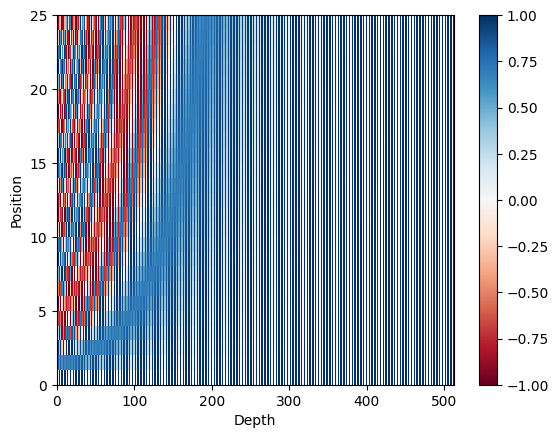

In [3]:
# PositionalEncoding 시각화
sample_pos_encoding = PositionalEncoding(25, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

---
#### scaled dot product

In [4]:
def scaled_dot_product_attention(query, key, value, mask=None):

    # 1) Q와 K의 내적을 통해 score(유사도) 계산
    # key.transpose(-1, -2): (batch_size, heads, depth, seq_len)
    # matmul 결과 shape: (batch_size, heads, seq_len, seq_len)
    matmul_qk = torch.matmul(query, key.transpose(-1, -2))

    # 2) depth에 따라 정규화
    depth = key.size(-1)  # depth = d_model / heads
    logits = matmul_qk / math.sqrt(depth)

    # 3) 마스크가 주어졌다면 -1e9(아주 작은 값)를 더해 소프트맥스에서 제외시키도록 함
    if mask is not None:
        # 텐서플로우: logits += (mask * -1e9)
        # 파이토치 동일 적용
        logits = logits + (mask * -1e9)

    # 4) 소프트맥스 계산해 attention weights 생성
    attention_weights = F.softmax(logits, dim=-1)

    # 5) attention weights와 value의 내적
    output = torch.matmul(attention_weights, value)

    return output, attention_weights

---
#### MultiHeadAttention

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        # d_model은 num_heads로 나누어떨어져야 함
        assert d_model % num_heads == 0

        self.depth = d_model // num_heads

        # 파이토치에서 Dense는 nn.Linear로 대응
        self.query_dense = nn.Linear(d_model, d_model)
        self.key_dense = nn.Linear(d_model, d_model)
        self.value_dense = nn.Linear(d_model, d_model)

        self.out_dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        """
        x: (batch_size, seq_len, d_model)
        => (batch_size, num_heads, seq_len, depth) 형태로 변환
        """
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        x = x.permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, depth)
        return x

    def forward(self, query, key, value, mask=None):
        """
        query, key, value: (batch_size, seq_len, d_model)
        mask: (batch_size, 1, seq_len, seq_len) 등으로 broadcast 가능하도록 구성
        """
        batch_size = query.size(0)

        # Q, K, V에 각각 Linear 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Head 분할
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)

        # (batch_size, num_heads, seq_len, depth) -> (batch_size, seq_len, num_heads, depth)
        scaled_attention = scaled_attention.permute(0, 2, 1, 3).contiguous()

        # 다시 (batch_size, seq_len, d_model)로 합치기
        concat_attention = scaled_attention.view(batch_size, -1, self.d_model)

        # 최종 Dense
        output = self.out_dense(concat_attention)
        return output


---
#### masked

In [6]:
def create_padding_mask(x):
    # x == 0 위치를 찾아 float형 1로 변환
    mask = (x == 0).float()
    # (batch_size, seq_len) -> (batch_size, 1, 1, seq_len)
    mask = mask.unsqueeze(1).unsqueeze(2)
    return mask

In [7]:
def create_look_ahead_mask(x):
    seq_len = x.size(1)

    # (seq_len, seq_len) 크기의 하삼각 행렬(tril) 생성 후 1에서 빼서
    # 상삼각이 1, 하삼각(자기 자신 포함)이 0이 되도록 설정
    # => 미래 토큰(자신 인덱스보다 큰 위치) 마스킹
    look_ahead_mask = 1 - torch.tril(torch.ones((seq_len, seq_len)))

    # 패딩 마스크 생성 (shape: (batch_size, 1, 1, seq_len))
    padding_mask = create_padding_mask(x)

    # look_ahead_mask: (seq_len, seq_len) -> (1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(0)
    # -> (1, seq_len, seq_len) -> (1, 1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(1)
    look_ahead_mask = look_ahead_mask.to(x.device)

    # look-ahead 마스크와 패딩 마스크를 합성 (둘 중 하나라도 1이면 마스킹)
    # 최종 shape은 브로드캐스팅으로 (batch_size, 1, seq_len, seq_len)
    combined_mask = torch.max(look_ahead_mask, padding_mask)
    return combined_mask

In [8]:
x = torch.tensor([[1, 2, 0, 3, 0],
                  [0, 0, 0, 4, 5]])
mask = create_padding_mask(x)
print("입력 텐서 크기 :", x.shape)    # (2, 5)
print("생성된 마스크 크기 :", mask.shape)  # (2, 1, 1, 5)
print(mask)

입력 텐서 크기 : torch.Size([2, 5])
생성된 마스크 크기 : torch.Size([2, 1, 1, 5])
tensor([[[[0., 0., 1., 0., 1.]]],


        [[[1., 1., 1., 0., 0.]]]])


In [9]:
x = torch.tensor([[1, 2, 3, 4, 5]])
mask_1 = create_look_ahead_mask(x)
print("첫 번째 시퀀스:\n", mask_1, mask_1.shape)

첫 번째 시퀀스:
 tensor([[[[0., 1., 1., 1., 1.],
          [0., 0., 1., 1., 1.],
          [0., 0., 0., 1., 1.],
          [0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 0.]]]]) torch.Size([1, 1, 5, 5])


In [10]:
x2 = torch.tensor([[0, 5, 1, 5, 5]])
mask_2 = create_look_ahead_mask(x2)
print("두 번째 시퀀스:\n", mask_2, mask_2.shape)

두 번째 시퀀스:
 tensor([[[[1., 1., 1., 1., 1.],
          [1., 0., 1., 1., 1.],
          [1., 0., 0., 1., 1.],
          [1., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0.]]]]) torch.Size([1, 1, 5, 5])


---
#### Encoder&Decoder

In [11]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)  # 이전에 구현한 MHA
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 피드포워드 부분 (Dense -> ReLU -> Dense)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, d_model)
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

    def forward(self, x, mask=None):
        # (1) 멀티 헤드 어텐션 (셀프 어텐션)
        attn_output = self.mha(x, x, x, mask)  # (batch_size, seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(x + attn_output)     # 잔차 연결 + LayerNorm

        # (2) 피드포워드 신경망
        ffn_output = self.ffn(out1)            # (batch_size, seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.norm2(out1 + ffn_output)   # 잔차 연결 + LayerNorm

        return out2


In [12]:
class Encoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) EncoderLayer 쌓기
        self.enc_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        # (1) 임베딩 & sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 적용 + 드롭아웃
        x = self.pos_encoding(x)  # shape: (batch_size, seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓아올린 EncoderLayer 통과
        for layer in self.enc_layers:
            x = layer(x, mask)

        return x

In [13]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # 첫 번째 서브 레이어 (디코더 내부 셀프 어텐션)
        self.self_mha = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 두 번째 서브 레이어 (인코더-디코더 어텐션)
        self.encdec_mha = MultiHeadAttention(d_model, num_heads)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

        # 세 번째 서브 레이어 (피드포워드 네트워크)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),  # Dense(units=ff_dim)
            nn.ReLU(),                   # activation='relu'
            nn.Linear(ff_dim, d_model)   # Dense(units=d_model)
        )
        self.norm3 = nn.LayerNorm(d_model, eps=1e-6)

        # 드롭아웃
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        # 1) 셀프 어텐션 (디코더 내부)
        self_attn_out = self.self_mha(x, x, x, mask=look_ahead_mask)
        self_attn_out = self.dropout1(self_attn_out)
        out1 = self.norm1(x + self_attn_out)  # 잔차 연결 + LayerNorm

        # 2) 인코더-디코더 어텐션
        encdec_attn_out = self.encdec_mha(out1, enc_outputs, enc_outputs, mask=padding_mask)
        encdec_attn_out = self.dropout2(encdec_attn_out)
        out2 = self.norm2(out1 + encdec_attn_out)  # 잔차 연결 + LayerNorm

        # 3) 피드포워드 (Dense -> ReLU -> Dense)
        ffn_out = self.ffn(out2)
        ffn_out = self.dropout3(ffn_out)
        out3 = self.norm3(out2 + ffn_out)  # 잔차 연결 + LayerNorm

        return out3

In [14]:
class Decoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        # 실제 학습 시에는 최대 시퀀스 길이에 맞추어 쓰기도 함
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) DecoderLayer 쌓기
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        # (1) 임베딩 + sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 + 드롭아웃
        x = self.pos_encoding(x)    # (batch_size, tgt_seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓인 DecoderLayer 통과
        for layer in self.dec_layers:
            x = layer(x, enc_outputs, look_ahead_mask, padding_mask)

        return x

---
#### model 정의

In [15]:
class Transformer(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,      # 인코더/디코더 층 수
                 units,           # feed-forward 네트워크의 중간 차원(ff_dim)
                 d_model,         # 임베딩 및 내부 표현 차원
                 num_heads,       # 멀티헤드 어텐션의 헤드 수
                 dropout=0.1):
        super(Transformer, self).__init__()

        # 인코더
        self.encoder = Encoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 디코더
        self.decoder = Decoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 최종 출력층: (d_model) -> (vocab_size)
        self.final_linear = nn.Linear(d_model, vocab_size)

        # 참고: 텐서플로우 코드의 `name="transformer"`는 파이토치에선 보통 사용 안 함

    def forward(self, inputs, dec_inputs):
        # 1) 인코더 패딩 마스크 생성
        enc_padding_mask = create_padding_mask(inputs)     # shape (batch_size, 1, 1, src_seq_len)

        # 2) 디코더 look-ahead + 패딩 마스크
        look_ahead_mask = create_look_ahead_mask(dec_inputs)  # shape (batch_size, 1, tgt_seq_len, tgt_seq_len)

        # 3) 디코더에서 인코더 출력 쪽을 마스킹할 때 쓸 패딩 마스크
        dec_padding_mask = create_padding_mask(inputs)        # shape (batch_size, 1, 1, src_seq_len)

        # 4) 인코더 수행
        enc_outputs = self.encoder(
            x=inputs,
            mask=enc_padding_mask
        )  # shape: (batch_size, src_seq_len, d_model)

        # 5) 디코더 수행
        dec_outputs = self.decoder(
            x=dec_inputs,           # (batch_size, tgt_seq_len)
            enc_outputs=enc_outputs,# (batch_size, src_seq_len, d_model)
            look_ahead_mask=look_ahead_mask,
            padding_mask=dec_padding_mask
        )  # shape: (batch_size, tgt_seq_len, d_model)

        # 6) 최종 Dense (vocab_size)
        logits = self.final_linear(dec_outputs)  # (batch_size, tgt_seq_len, vocab_size)
        return logits

---
#### data module

In [16]:
def analyze_and_plot(df, columns, limit_len=25):
    """
    텍스트 데이터의 길이 통계, 특정 길이 포함 비율 확인 및 시각화를 수행합니다.
    """
    plt.figure(figsize=(12, 5))
    
    for i, col in enumerate(columns):
        # 1. 길이 계산
        lengths = df[col].apply(len)
        
        # 2. 통계치 산출
        mean_val = lengths.mean()
        median_val = lengths.median()
        max_val = lengths.max()
        
        # 3. 포함 비율 계산 (평균 기준 & 사용자 입력 기준)
        mean_coverage = (lengths <= mean_val).sum() / len(lengths) * 100
        limit_coverage = (lengths <= limit_len).sum() / len(lengths) * 100
        
        # 4. 텍스트 통계 출력
        print(f"[{col} 데이터 통계]")
        print(f" - 평균: {mean_val:.2f} / 중앙값: {median_val} / 최대: {max_val}")
        print(f" - 평균({mean_val:.2f}) 이하 포함 비율: {mean_coverage:.2f}%")
        print(f" - 설정 길이({limit_len}) 이하 포함 비율: {limit_coverage:.2f}%")
        print("-" * 40)
        
        # 5. 히스토그램 시각화
        plt.subplot(1, len(columns), i + 1)
        plt.hist(lengths, bins=30, alpha=0.7, color='skyblue' if i==0 else 'salmon')
        plt.axvline(limit_len, color='red', linestyle='--', label=f'Limit ({limit_len})')
        plt.title(f'{col} Length Distribution')
        plt.xlabel('Length')
        plt.ylabel('Count')
        plt.legend()

    plt.tight_layout()
    plt.show()

In [17]:
def preprocess_sentence(sentence):
    # 1. 양쪽 공백 제거
    sentence = sentence.strip()

    # 2. 단어와 구두점(?.!,) 사이의 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # 3. 한글(가-힣, ㄱ-ㅎ, ㅏ-ㅣ)과 구두점(?.!,)을 제외한 모든 문자를 공백으로 대체
    # 영어도 함께 남기고 싶다면 a-zA-Z를 추가하세요.
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9?.!,]+", " ", sentence)
    
    # 4. 다시 양쪽 공백 제거 및 불필요한 공백 정리
    sentence = sentence.strip()
    return sentence

In [18]:
class CornellDataset(Dataset):
    def __init__(self, pairs, sp, max_length=40):
        super().__init__()
        self.sp = sp
        self.max_length = max_length
        self.data = []

        for q_text, a_text in pairs:
            # 1) 토크나이즈
            q_ids = sp.EncodeAsIds(q_text)
            a_ids = sp.EncodeAsIds(a_text)

            # 2) [CLS]/[SEP] 같은 별도 스페셜 토큰을 쓸 수도 있으나,
            #    여기서는 SentencePiece 기본 <s>, </s> 등 혹은 사용자 정의 토큰 활용 가능
            #    간단히 <s>=sp.bos_id(), </s>=sp.eos_id()로 가정해본다면:
            #    sp.SetEncodeExtraOptions("bos:eos") 등으로 설정하는 방법도 있음.
            # 여기서는 수동으로 bos/eos id를 붙인다고 가정
            bos_id = sp.bos_id() if sp.bos_id() >= 0 else 1  # 혹은 임의값
            eos_id = sp.eos_id() if sp.eos_id() >= 0 else 2

            q_tokens = [bos_id] + q_ids + [eos_id]
            a_tokens = [bos_id] + a_ids + [eos_id]

            # 3) 길이 제한
            if len(q_tokens) > max_length or len(a_tokens) > max_length:
                continue

            # 4) 고정 길이 패딩
            q_tokens += [0]*(max_length - len(q_tokens))  # 0 -> <pad> 가정
            a_tokens += [0]*(max_length - len(a_tokens))

            # 5) 디코더 입력(dec_input): a_tokens[:-1], 타겟(outputs): a_tokens[1:]
            #    (teacher forcing용)
            dec_input = a_tokens[:-1]
            target = a_tokens[1:]

            self.data.append({
                "enc_input": q_tokens,
                "dec_input": dec_input,
                "target": target
            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        enc_input = torch.tensor(sample["enc_input"], dtype=torch.long)
        dec_input = torch.tensor(sample["dec_input"], dtype=torch.long)
        target = torch.tensor(sample["target"], dtype=torch.long)
        return enc_input, dec_input, target

---
#### scheduler 정의

In [19]:
# Noam Scheduler
def get_lr_lambda(d_model, warmup_steps=4000):
    d_model = float(d_model)
    def lr_lambda(step):
        # step은 0부터 시작하므로 +1로 보정
        step = step + 1
        return (d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))
    return lr_lambda

In [20]:
# cosine Warmup
def get_cosine_with_warmup_lr_lambda(total_steps, warmup_steps, min_lr_ratio=1e-7):
    def lr_lambda(current_step):
        # 1. Linear Warmup 구간
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        
        # 2. Cosine Annealing 구간
        progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        
        # cosine_decay는 1.0 ~ min_lr_ratio로 변함
        cosine_decay = 0.5 * (1.0 + math.cos(math.pi * progress))
        
        # (1.0 - min_lr_ratio) 범위를 곱해주고 마지막에 min_lr_ratio를 더함
        return min_lr_ratio + (1.0 - min_lr_ratio) * cosine_decay
        
    return lr_lambda

---
#### train 정의

In [21]:
def accuracy_function(y_pred, y_true, pad_id=0):
    """
    y_pred: (batch_size, seq_len, vocab_size)
    y_true: (batch_size, seq_len)|
    """
    preds = y_pred.argmax(dim=-1)  # (batch_size, seq_len)
    mask = (y_true != pad_id)
    correct = (preds == y_true) & mask
    acc = correct.float().sum() / mask.float().sum()
    return acc

In [22]:
def train_step(model, batch, optimizer, loss_function, device):
    model.train()
    enc_input, dec_input, target = [x.to(device) for x in batch]

    optimizer.zero_grad()

    # 모델 포워드 패스
    logits = model(enc_input, dec_input)  # (batch_size, seq_len, vocab_size)

    # Loss 계산 (패딩 토큰 무시)
    loss = loss_function(logits.permute(0, 2, 1), target)  # (batch_size, vocab_size, seq_len) 필요

    # Backpropagation
    loss.backward()
    optimizer.step()

    return loss.item(), accuracy_function(logits, target, pad_id=sp.pad_id())

In [23]:
def train(model, dataloader, optimizer, loss_function, scheduler, num_epochs, device, save_path="checkpoints"):
    model.to(device)

    # best_avg_loss = float('inf')
    # best_epoch = 0

    # 1. 저장 디렉토리 생성
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    for epoch in range(num_epochs):
        total_loss, total_acc = 0, 0
        for step, batch in enumerate(dataloader):
            loss, acc = train_step(model, batch, optimizer, loss_function, device)
            total_loss += loss
            total_acc += acc

            if step % 100 == 0:
                print(f"[Epoch {epoch+1}, Step {step}] Loss: {loss:.4f}, Acc: {acc:.4f}")

            # 학습률 스케줄러 업데이트
            scheduler.step()

        avg_loss = total_loss / len(dataloader)
        avg_acc = total_acc / len(dataloader)
        print(f"Epoch {epoch+1} Completed - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.4f}")
        
        # --- 2. 20 에포크마다 체크포인트 저장 ---
        if (epoch + 1) % 20 == 0 or (epoch + 1 == num_epochs) :
            checkpoint_file = os.path.join(save_path, f"checkpoint_epoch_{epoch+1}.pt")
            
            # 모델 가중치, 옵티마이저, 스케줄러 상태를 모두 저장 (재개 가능하도록)
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': avg_loss,
            }, checkpoint_file)
            
            print(f"==> Checkpoint saved: {checkpoint_file}")
        
        # if best_avg_loss > avg_loss:
        #     best_avg_loss = avg_loss
        #     best_epoch = epoch + 1

        #     torch.save(model.state_dict(), 'checkpoints/best_model.pt')
        #     print(f"==> Best Model Saved at Epoch {best_epoch}")

# checkpoint = torch.load('checkpoints/checkpoint_epoch_10.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

--- 
### 데이터 증강 X

In [26]:
# 하이퍼파라미터 설정
NUM_LAYERS = 3     # 인코더/디코더 층 수
D_MODEL = 256     # 임베딩 및 내부 표현 차원
UNITS = 512      # 피드포워드 신경망의 은닉 차원
DROPOUT = 0.2      # 드롭아웃 비율
VOCAB_SIZE = 5000 # 단어 집합 크기

sp_model_name = f'spm_uni_cornell_{VOCAB_SIZE}'     # sp 모델 이름
file_path = './data/ChatbotData.csv'                  # 파일 경로 설정 
corpus_file = "clean_corpus.txt"                      # sentencepiece corpus 파일

#### 데이터 불러오기

In [27]:
try:
    df = pd.read_csv(file_path, encoding='utf-8-sig')

    # 구조 확인 (Q, A, label 컬럼이 있는지 확인)
    expected_columns = ['Q', 'A', 'label']
    if all(col in df.columns for col in expected_columns):
        print("데이터 로드 성공: 지정된 컬럼(Q, A, label)을 모두 포함하고 있습니다.")
    else:
        print(f"주의: 컬럼 구성이 다릅니다. 현재 컬럼: {list(df.columns)}")

    # 데이터 샘플 확인
    print(df.head())

except FileNotFoundError:
    print(f"오류: '{file_path}' 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
except Exception as e:
    print(f"오류 발생: {e}")

데이터 로드 성공: 지정된 컬럼(Q, A, label)을 모두 포함하고 있습니다.
                 Q            A  label
0           12시 땡!   하루가 또 가네요.      0
1      1지망 학교 떨어졌어    위로해 드립니다.      0
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
4          PPL 심하네   눈살이 찌푸려지죠.      0


In [28]:
# 글자 한 개인 행 제거
df = df[df.apply(lambda row: len(str(row['Q'])) > 1 and len(str(row['A'])) > 1, axis=1)]
df = df.reset_index(drop=True)

# 데이터 전처리
df['Q'] = df['Q'].apply(preprocess_sentence)
df['A'] = df['A'].apply(preprocess_sentence)

questions = df['Q'].tolist()
answers = df['A'].tolist()
pairs = list(zip(questions, answers))

print('전체 샘플 수 :', len(questions))
print('전처리 후 Q 샘플 :', questions[0])
print('전처리 후 A 샘플 :', answers[0])

전체 샘플 수 : 11812
전처리 후 Q 샘플 : 12시 땡 !
전처리 후 A 샘플 : 하루가 또 가네요 .


---
#### sentencepiece 모델 학습

In [29]:
with open(corpus_file, 'w', encoding='utf-8') as f:
    for q, a in pairs:
        f.write(q + "\n")
        f.write(a + "\n")

In [30]:
spm.SentencePieceTrainer.Train(
    input=corpus_file,
    model_prefix=sp_model_name,
    vocab_size=VOCAB_SIZE,
    character_coverage=0.9995,
    model_type="unigram",
    max_sentence_length=999999,
    bos_id=1,  # <s> (Beginning of Sentence) 설정
    eos_id=2,  # </s> (End of Sentence) 설정
    pad_id=0,  # Padding ID 설정
    unk_id=3   # Unknown Token ID 설정
)


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: clean_corpus.txt
  input_format: 
  model_prefix: spm_uni_cornell_5000
  model_type: UNIGRAM
  vocab_size: 5000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 999999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_p

In [31]:
sp = spm.SentencePieceProcessor()
sp.load(f'{sp_model_name}.model')

True

In [32]:
# 예제 문장
sentence = "12시 땡! 하루가 또 가네요..ㅠㅠ"

sentence = preprocess_sentence(sentence)
print("전처리 후의 문장:", sentence)

# 1. 토크나이징 (subword 단위로 분할)
tokens = sp.encode(sentence, out_type=str)
print("Tokenized:", tokens)

# 2. 인코딩 (서브워드를 정수 ID로 변환)
encoded = sp.encode(sentence, out_type=int)
print("Encoded:", encoded)

# 3. 디코딩 (정수 ID → 원본 문장 복원)
decoded = sp.decode(encoded)
print("Decoded:", decoded)


전처리 후의 문장: 12시 땡 ! 하루가 또 가네요 . . ㅠㅠ
Tokenized: ['▁12', '시', '▁', '땡', '▁!', '▁하루', '가', '▁또', '▁가', '네요', '▁.', '▁.', '▁ᅲᅲ']
Encoded: [4168, 282, 5, 4786, 52, 279, 7, 112, 102, 26, 4, 4, 1765]
Decoded: 12시 땡 ! 하루가 또 가네요 . . ᅲᅲ


---
#### 데이터셋 구현

[Q 데이터 통계]
 - 평균: 13.24 / 중앙값: 12.0 / 최대: 57
 - 평균(13.24) 이하 포함 비율: 60.44%
 - 설정 길이(25) 이하 포함 비율: 94.96%
----------------------------------------
[A 데이터 통계]
 - 평균: 16.05 / 중앙값: 15.0 / 최대: 78
 - 평균(16.05) 이하 포함 비율: 60.94%
 - 설정 길이(25) 이하 포함 비율: 92.08%
----------------------------------------


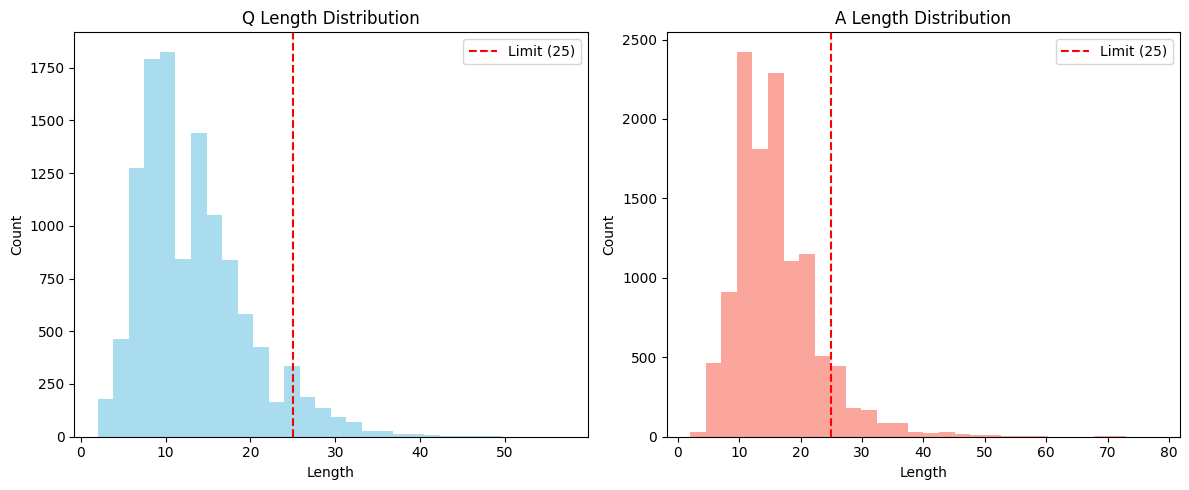

In [33]:
analyze_and_plot(df, columns=['Q', 'A'], limit_len=LIMIT_LEN)

In [34]:
dataset = CornellDataset(pairs, sp, max_length=LIMIT_LEN)

In [35]:
for encoder_input, decoder_input, decoder_label  in dataset:
    print("텐서 크기 :",encoder_input.size())
    print(encoder_input)
    print(sp.decode(encoder_input.tolist()))
    print(decoder_input)
    print(sp.decode(decoder_input.tolist()))
    print(decoder_label)
    print(sp.decode(decoder_label.tolist()))
    break

텐서 크기 : torch.Size([25])
tensor([   1, 4168,  282,    5, 4786,   52,    2,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0])
12시 땡 !
tensor([  1, 279,   7, 112, 102,  26,   4,   2,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0])
하루가 또 가네요 .
tensor([279,   7, 112, 102,  26,   4,   2,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0])
하루가 또 가네요 .


 DataLoader 구성하기

In [36]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE,shuffle=True)

In [37]:
for encoder_input, decoder_input, decoder_label in dataloader:
    print(encoder_input.size())
    print(decoder_input.size())
    print(decoder_label.size())
    break

torch.Size([32, 25])
torch.Size([32, 24])
torch.Size([32, 24])


---
#### model 선언

In [38]:
# 모델 생성
model = Transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)
model = model.to(device)
print(model)

Transformer(
  (encoder): Encoder(
    (embedding): Embedding(5000, 256)
    (pos_encoding): PositionalEncoding()
    (dropout): Dropout(p=0.2, inplace=False)
    (enc_layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (mha): MultiHeadAttention(
          (query_dense): Linear(in_features=256, out_features=256, bias=True)
          (key_dense): Linear(in_features=256, out_features=256, bias=True)
          (value_dense): Linear(in_features=256, out_features=256, bias=True)
          (out_dense): Linear(in_features=256, out_features=256, bias=True)
        )
        (dropout1): Dropout(p=0.2, inplace=False)
        (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=256, bias=True)
        )
        (dropout2): Dropout(p=0.2, inplace=False)
        (norm2): LayerNorm((256,), eps=1e-06, elementwise_aff

In [39]:
# MultiHeadAttention의 가중치 check
target_mha = model.encoder.enc_layers[0].mha
weight = target_mha.query_dense.weight

# 1번 헤드(0~31행)와 2번 헤드(32~63행) 가중치 비교
head1_w = weight[:64, :]
head2_w = weight[64:128, :]

print("두 가중치가 같은가? :", torch.equal(head1_w, head2_w))

두 가중치가 같은가? : False


---
#### scheduler 선언

In [40]:
# 하이퍼파라미터 설정
TOTAL_STEPS = len(dataloader) * EPOCH
WARMUP_STEPS  = int(TOTAL_STEPS * 0.1)

In [41]:
# Linear Warmup lr
noam_lr = lr * math.sqrt(D_MODEL) * math.sqrt(WARMUP_STEPS)

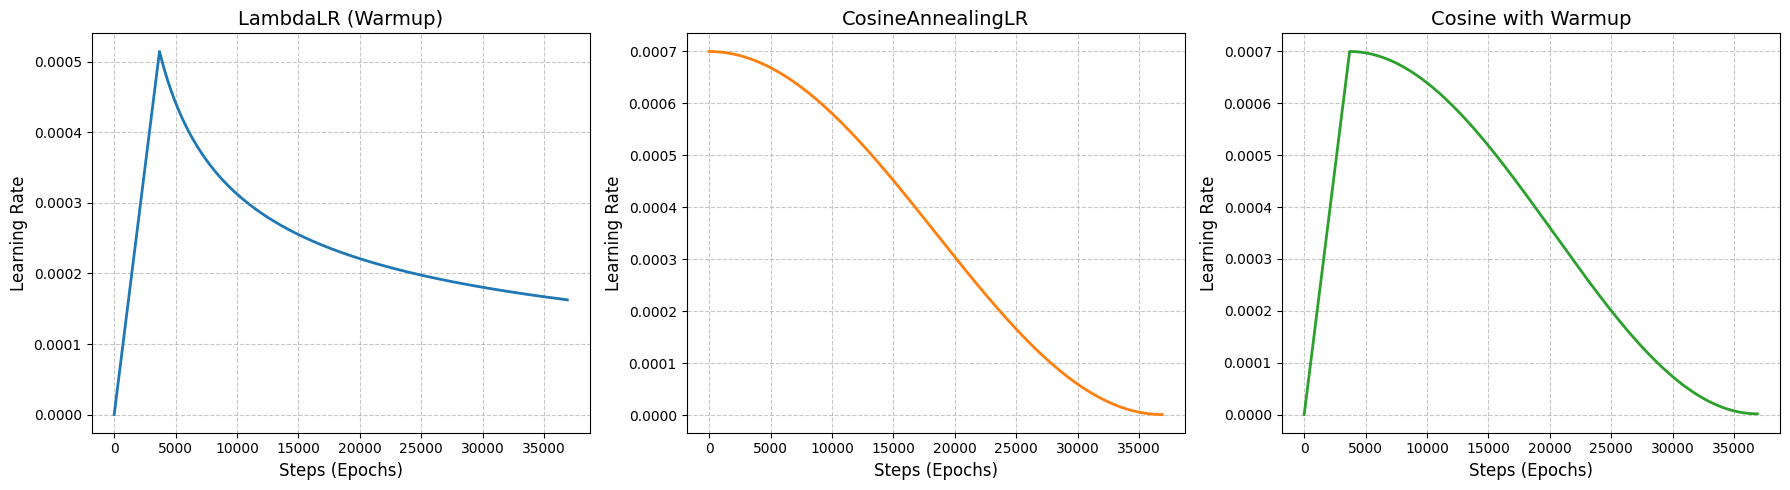

In [42]:
# 스케줄러 시각화
def get_lr_history(scheduler, optimizer, total_steps):
    history = []
    for _ in range(total_steps):
        history.append(optimizer.param_groups[0]['lr'])
        # 실제 학습 시에는 optimizer.step()이 먼저 호출됨
        optimizer.step()
        scheduler.step()
    return history

# 2. 각 케이스별 시뮬레이션
# Case 1: LambdaLR (Custom Warmup)
model_1 = nn.Linear(D_MODEL, VOCAB_SIZE)
opt_1 = optim.Adam(model_1.parameters(), lr = 0.5, betas=(0.9, 0.98), weight_decay=0.01)
sched_1 = torch.optim.lr_scheduler.LambdaLR(opt_1, lr_lambda=get_lr_lambda(D_MODEL, WARMUP_STEPS))
hist_1 = get_lr_history(sched_1, opt_1, TOTAL_STEPS)

# Case 2: CosineAnnealingLR
model_2 = nn.Linear(D_MODEL, VOCAB_SIZE)
opt_2 = optim.AdamW(model_2.parameters(), lr=lr)
sched_2 = torch.optim.lr_scheduler.CosineAnnealingLR(opt_2, T_max=TOTAL_STEPS, eta_min=1e-6)
hist_2 = get_lr_history(sched_2, opt_2, TOTAL_STEPS)

# Case 3: Cosine Decay with Warmup
model_3 = nn.Linear(D_MODEL, VOCAB_SIZE)
opt_3 = optim.AdamW(model_3.parameters(), lr=lr)
sched_3 = torch.optim.lr_scheduler.LambdaLR(opt_3, lr_lambda=get_cosine_with_warmup_lr_lambda(TOTAL_STEPS, WARMUP_STEPS, min_lr_ratio=2e-3))
hist_3 = get_lr_history(sched_3, opt_3, TOTAL_STEPS)

# 3. 가로로 3개 출력 (시각화)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
titles = ['LambdaLR (Warmup)', 'CosineAnnealingLR', 'Cosine with Warmup']
histories = [hist_1, hist_2, hist_3]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, ax in enumerate(axes):
    ax.plot(range(TOTAL_STEPS), histories[i], color=colors[i], linewidth=2)
    ax.set_title(titles[i], fontsize=14)
    ax.set_xlabel('Steps (Epochs)', fontsize=12)
    ax.set_ylabel('Learning Rate', fontsize=12)
    # ax.set_yscale('log')
    # ax.set_ylim(1e-9, 2e-3)
    ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [43]:
# AdamW + 선형 워밍업
optimizer = optim.AdamW(model.parameters(), lr = noam_lr, betas=(0.9, 0.98), weight_decay=0.01)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps=WARMUP_STEPS))

In [44]:
# # AdamW + 코사인 어닐링
# optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.98), weight_decay=0.01)

# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=TOTAL_STEPS, eta_min=1e-6)

In [45]:
# # AdamW +  코사인 워밍업
# optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.98), weight_decay=0.01)
# scheduler = lr_scheduler.LambdaLR(
#     optimizer,
#     lr_lambda=get_cosine_with_warmup_lr_lambda(
#         total_steps=TOTAL_STEPS,
#         warmup_steps=WARMUP_STEPS,
#         # min_lr_ratio=2e-3
#     )
# )

---
#### train

In [46]:
loss_function = nn.CrossEntropyLoss(ignore_index=sp.pad_id())

In [47]:
%%time
train(
    model=model,
    dataloader=dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    scheduler=scheduler,
    num_epochs=EPOCH,  # 원하는 에폭 수
    device=device
)

[Epoch 1, Step 0] Loss: 8.5804, Acc: 0.0000
[Epoch 1, Step 100] Loss: 7.5475, Acc: 0.1836
[Epoch 1, Step 200] Loss: 6.3856, Acc: 0.2451
[Epoch 1, Step 300] Loss: 5.7579, Acc: 0.2700
Epoch 1 Completed - Avg Loss: 6.8255, Avg Acc: 0.1946
[Epoch 2, Step 0] Loss: 5.5267, Acc: 0.2442
[Epoch 2, Step 100] Loss: 5.3076, Acc: 0.2482
[Epoch 2, Step 200] Loss: 5.3338, Acc: 0.2321
[Epoch 2, Step 300] Loss: 5.0538, Acc: 0.2891
Epoch 2 Completed - Avg Loss: 5.2199, Avg Acc: 0.2673
[Epoch 3, Step 0] Loss: 4.9635, Acc: 0.3014
[Epoch 3, Step 100] Loss: 4.5503, Acc: 0.3232
[Epoch 3, Step 200] Loss: 4.7228, Acc: 0.3132
[Epoch 3, Step 300] Loss: 4.6514, Acc: 0.3029
Epoch 3 Completed - Avg Loss: 4.7277, Avg Acc: 0.3131
[Epoch 4, Step 0] Loss: 4.7100, Acc: 0.3182
[Epoch 4, Step 100] Loss: 4.5737, Acc: 0.3037
[Epoch 4, Step 200] Loss: 4.2476, Acc: 0.3296
[Epoch 4, Step 300] Loss: 4.3350, Acc: 0.3460
Epoch 4 Completed - Avg Loss: 4.3254, Avg Acc: 0.3452
[Epoch 5, Step 0] Loss: 3.9531, Acc: 0.3906
[Epoch 5, St

---
### 데이터 증강 버전

In [48]:
# 하이퍼파라미터 설정
NUM_LAYERS = 4     # 인코더/디코더 층 수
D_MODEL = 512     # 임베딩 및 내부 표현 차원
UNITS = 2048      # 피드포워드 신경망의 은닉 차원
DROPOUT = 0.3      # 드롭아웃 비율
VOCAB_SIZE = 7000 # 단어 집합 크기
MAX_SAMPLES = 30000   # 최대 샘플 수 제한
# BATCH_SIZE = 64   # 배치 사이즈

vec_path = 'cc.ko.300.vec'
sp_model_name = f'spm_uni_cornell_aug_{VOCAB_SIZE}' # sp 모델 이름
corpus_file = "clean_corpus_aug.txt"                # sentencepiece corpus 파일
file_path = './data/ChatbotData.csv'                # 원본 파일 경로 설정 
aug_file_path = './data/augmented_ChatbotData.csv'  # 증강 파일 경로

---
#### 데이터 증강
증강 파일이 없을 떄 실행

In [49]:
import random
from konlpy.tag import Okt
from tqdm import tqdm
from gensim.models import KeyedVectors

In [50]:
class ChatbotDataAugmenter:
    def __init__(self, original_pairs, vector_path, limit=200000):
        self.original_pairs = original_pairs

        self.word_vectors = KeyedVectors.load_word2vec_format(vec_path, limit=limit)
        self.synonym_map = {}
        self.okt = Okt()

    def prepare_synonyms(self):
        """코퍼스 내 주요 단어의 유의어 사전 구축"""
        all_text = " ".join([str(q) + " " + str(a) for q, a in self.original_pairs])
        # 명사, 동사, 형용사 원형 추출
        words = {w for w, p in self.okt.pos(all_text, stem=True) if p in ['Noun', 'Verb', 'Adjective']}
        
        print(f"총 {len(words)}개의 고유 단어 분석 중...")
        for word in tqdm(words):
            if word in self.word_vectors:
                try:
                    # 유사도 0.75 이상의 유의어 추출
                    results = self.word_vectors.most_similar(word, topn=5)
                    valid = [syn for syn, score in results if score >= 0.7]
                    if valid:
                        self.synonym_map[word] = valid
                except KeyError:
                    continue

    def _smart_process(self, text):
        """형태소를 분석하여 품사를 유지한 채 유의어 교체"""
        pos_tags = self.okt.pos(text) 
        new_sentence = []
        changed = False

        for word, pos in pos_tags:
            # 명사, 동사, 형용사이고 유의어 사전에 원형이 있는 경우
            stem_word = self.okt.morphs(word, stem=True)[0]
            if pos in ['Noun', 'Verb', 'Adjective'] and stem_word in self.synonym_map:
                if random.random() < 0.3: # 교체 확률 30%로 조정 (품질 유지)
                    synonym = random.choice(self.synonym_map[stem_word])
                    new_sentence.append(synonym)
                    changed = True
                else:
                    new_sentence.append(word)
            else:
                new_sentence.append(word)
        
        return "".join(new_sentence) if changed else None

    def augment(self, max_samples=30000, max_attempts_factor=5):
        unique_pairs = {tuple(pair) for pair in self.original_pairs}
        original_list = list(self.original_pairs)
        
        self.prepare_synonyms()
        
        print(f"증강 시작 (목표: {max_samples}개)...")
        pbar = tqdm(total=max_samples)
        pbar.update(len(unique_pairs))

        attempts = 0
        max_attempts = max_samples * max_attempts_factor # 무한 루프 방지

        while len(unique_pairs) < max_samples and attempts < max_attempts:
            attempts += 1
            q, a = random.choice(original_list)
            
            new_q = self._smart_process(str(q))
            new_a = self._smart_process(str(a))
            
            if new_q or new_a:
                res_q = new_q if new_q else str(q)
                res_a = new_a if new_a else str(a)
                
                if (res_q, res_a) not in unique_pairs:
                    unique_pairs.add((res_q, res_a))
                    pbar.update(1)
                    
        pbar.close()
        if len(unique_pairs) < max_samples:
            print(f"경고: 가능한 조합을 모두 소진하여 {len(unique_pairs)}개에서 중단되었습니다.")
            
        return [list(x) for x in unique_pairs]

In [51]:
df = pd.read_csv(file_path)

# Q,A 중 글자가 한 개일 경우 제거
df = df[df.apply(lambda row: len(str(row['Q'])) > 1 and len(str(row['A'])) > 1, axis=1)]
df = df.reset_index(drop=True)

original_pairs = df[['Q', 'A']].values.tolist()

In [52]:
# # 한국어 단어 벡터(가중치) 파일 다운로드 (약 1.1GB)
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ko.300.vec.gz
# # 압축 해제
# !gunzip cc.ko.300.vec.gz

In [53]:
augmenter = ChatbotDataAugmenter(original_pairs, vec_path)

In [54]:
augmented_list = augmenter.augment(MAX_SAMPLES)

총 5216개의 고유 단어 분석 중...


100%|██████████| 5216/5216 [00:27<00:00, 188.80it/s]


증강 시작 (목표: 30000개)...


100%|██████████| 30000/30000 [02:00<00:00, 248.10it/s]   


In [55]:
augmented_df = pd.DataFrame(augmented_list, columns=['Q', 'A'])
augmented_df.to_csv(aug_file_path, index=False, encoding='utf-8-sig')

--- 
#### 데이터 불러오기

In [56]:
try:
    augmented_df = pd.read_csv(aug_file_path, encoding='utf-8-sig')

    # 구조 확인 (Q, A, label 컬럼이 있는지 확인)
    expected_columns = ['Q', 'A', 'label']
    if all(col in augmented_df.columns for col in expected_columns):
        print("데이터 로드 성공: 지정된 컬럼(Q, A, label)을 모두 포함하고 있습니다.")
    else:
        print(f"주의: 컬럼 구성이 다릅니다. 현재 컬럼: {list(augmented_df.columns)}")

    # 데이터 샘플 확인
    print(augmented_df.head())

except FileNotFoundError:
    print(f"오류: '{aug_file_path}' 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
except Exception as e:
    print(f"오류 발생: {e}")

주의: 컬럼 구성이 다릅니다. 현재 컬럼: ['Q', 'A']
                            Q                   A
0                 내가 주제를 몰랐나봐  주제를 모를 때가 행복할 때예요.
1               친구사그로도못지낼것같아.    계속 생각날테니 그럴만 해요.
2  여자친구가친구들이랑여행을가는데여자도있으면어떡해?  같이 가거나 신경쓰인다고 말해요.
3                해 뜨는 거 보고 잤어           몸이 힘들게네요.
4              내 의지로 안되는 일인가봐           제일중요한거예요.


In [57]:
# 사용할 샘플의 최대 개수
# augmented_df = augmented_df[:MAX_SAMPLES]

augmented_df['Q'] = augmented_df['Q'].apply(preprocess_sentence)
augmented_df['A'] = augmented_df['A'].apply(preprocess_sentence)

questions = augmented_df['Q'].tolist()
answers = augmented_df['A'].tolist()
pairs = list(zip(questions, answers))

print('전체 샘플 수 :', len(questions))
print('전처리 후 Q 샘플 :', questions[0])
print('전처리 후 A 샘플 :', answers[0])

전체 샘플 수 : 30000
전처리 후 Q 샘플 : 내가 주제를 몰랐나봐
전처리 후 A 샘플 : 주제를 모를 때가 행복할 때예요 .


---
#### sentencepiece 모델 학습

In [58]:
with open(corpus_file, 'w', encoding='utf-8') as f:
    for q, a in pairs:
        f.write(q + "\n")
        f.write(a + "\n")

In [59]:
spm.SentencePieceTrainer.Train(
    input=corpus_file,
    model_prefix=sp_model_name,
    vocab_size=VOCAB_SIZE,
    character_coverage=0.9995,
    model_type="unigram",
    max_sentence_length=999999,
    bos_id=1,  # <s> (Beginning of Sentence) 설정
    eos_id=2,  # </s> (End of Sentence) 설정
    pad_id=0,  # Padding ID 설정
    unk_id=3   # Unknown Token ID 설정
)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: clean_corpus_aug.txt
  input_format: 
  model_prefix: spm_uni_cornell_aug_7000
  model_type: UNIGRAM
  vocab_size: 7000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 999999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differ

In [60]:
sp = spm.SentencePieceProcessor()
sp.load(f'{sp_model_name}.model')

True

---
#### DataLoader 구현

[Q 데이터 통계]
 - 평균: 12.89 / 중앙값: 12.0 / 최대: 56
 - 평균(12.89) 이하 포함 비율: 55.97%
 - 설정 길이(25) 이하 포함 비율: 95.72%
----------------------------------------
[A 데이터 통계]
 - 평균: 15.03 / 중앙값: 14.0 / 최대: 76
 - 평균(15.03) 이하 포함 비율: 60.95%
 - 설정 길이(25) 이하 포함 비율: 93.55%
----------------------------------------


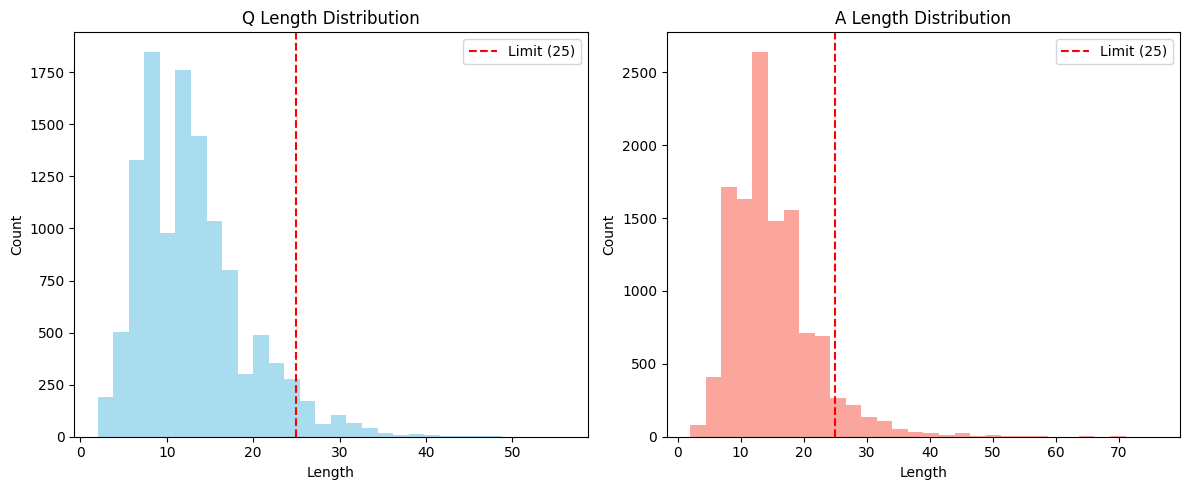

In [61]:
analyze_and_plot(df, columns=['Q', 'A'], limit_len=LIMIT_LEN)

In [62]:
dataset = CornellDataset(pairs, sp, max_length=LIMIT_LEN)

In [63]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE,shuffle=True)

---
#### model 선언

In [64]:
# 모델 생성
model_aug = Transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
).to(device)

print(model_aug)

Transformer(
  (encoder): Encoder(
    (embedding): Embedding(7000, 512)
    (pos_encoding): PositionalEncoding()
    (dropout): Dropout(p=0.3, inplace=False)
    (enc_layers): ModuleList(
      (0-3): 4 x EncoderLayer(
        (mha): MultiHeadAttention(
          (query_dense): Linear(in_features=512, out_features=512, bias=True)
          (key_dense): Linear(in_features=512, out_features=512, bias=True)
          (value_dense): Linear(in_features=512, out_features=512, bias=True)
          (out_dense): Linear(in_features=512, out_features=512, bias=True)
        )
        (dropout1): Dropout(p=0.3, inplace=False)
        (norm1): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout2): Dropout(p=0.3, inplace=False)
        (norm2): LayerNorm((512,), eps=1e-06, elementwise_a

---
#### scheduler 정의

In [65]:
# 하이퍼파라미터 설정
TOTAL_STEPS = len(dataloader) * EPOCH
WARMUP_STEPS  = int(TOTAL_STEPS * 0.1)

In [66]:
# Linear Warmup lr
noam_lr = lr * math.sqrt(D_MODEL) * math.sqrt(WARMUP_STEPS)

In [67]:
# AdamW + 선형 워밍업
optimizer = optim.AdamW(model_aug.parameters(), lr = noam_lr, betas=(0.9, 0.98), weight_decay=0.01)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps=WARMUP_STEPS))

In [68]:
# # AdamW + 코사인 어닐링
# optimizer = optim.AdamW(model_aug.parameters(), lr=lr, betas=(0.9, 0.98), weight_decay=0.01)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=TOTAL_STEPS, eta_min=1e-6)

In [69]:
# # AdamW +  코사인 워밍업
# optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.98), weight_decay=0.01)
# scheduler = lr_scheduler.LambdaLR(
#     optimizer,
#     lr_lambda=get_cosine_with_warmup_lr_lambda(
#         total_steps=TOTAL_STEPS,
#         warmup_steps=WARMUP_STEPS,
#         # min_lr_ratio=2e-3
#     )
# )

---
#### train

In [70]:
loss_function = nn.CrossEntropyLoss(ignore_index=sp.pad_id())

In [71]:
%%time
train(
    model=model_aug,
    dataloader=dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    scheduler=scheduler,
    num_epochs=EPOCH,       # 원하는 에폭 수
    device=device,
    save_path="checkpoints_aug"
)

[Epoch 1, Step 0] Loss: 9.0473, Acc: 0.0000
[Epoch 1, Step 100] Loss: 6.8822, Acc: 0.1993
[Epoch 1, Step 200] Loss: 6.1076, Acc: 0.2655
[Epoch 1, Step 300] Loss: 5.7575, Acc: 0.2724
[Epoch 1, Step 400] Loss: 5.6279, Acc: 0.2721
[Epoch 1, Step 500] Loss: 5.2347, Acc: 0.2918
[Epoch 1, Step 600] Loss: 5.3794, Acc: 0.2857
[Epoch 1, Step 700] Loss: 5.1384, Acc: 0.3123
[Epoch 1, Step 800] Loss: 5.0726, Acc: 0.3109
[Epoch 1, Step 900] Loss: 4.9176, Acc: 0.3071
Epoch 1 Completed - Avg Loss: 5.7804, Avg Acc: 0.2737
[Epoch 2, Step 0] Loss: 4.9645, Acc: 0.3058
[Epoch 2, Step 100] Loss: 4.9020, Acc: 0.3254
[Epoch 2, Step 200] Loss: 4.6459, Acc: 0.3509
[Epoch 2, Step 300] Loss: 4.6812, Acc: 0.3466
[Epoch 2, Step 400] Loss: 4.6368, Acc: 0.3219
[Epoch 2, Step 500] Loss: 4.3460, Acc: 0.3725
[Epoch 2, Step 600] Loss: 4.4774, Acc: 0.3580
[Epoch 2, Step 700] Loss: 4.1573, Acc: 0.3939
[Epoch 2, Step 800] Loss: 4.8711, Acc: 0.3007
[Epoch 2, Step 900] Loss: 4.4302, Acc: 0.3613
Epoch 2 Completed - Avg Loss: 

---
#### 챗봇 테스트하기

In [24]:
import glob
import re

import torch
import sentencepiece as spm

In [25]:
def decoder_inference(model, sentence, tokenizer, device='cpu'):
    START_TOKEN = tokenizer.bos_id()
    END_TOKEN = tokenizer.eos_id()
    MAX_LENGTH = 40

    # 전처리
    sentence = preprocess_sentence(sentence)

    # 인코더 입력: [START] + 인코딩 + [END]
    enc_input_ids = [START_TOKEN] + tokenizer.encode(sentence) + [END_TOKEN]
    # 차원 확장: (batch_size=1, seq_len)
    enc_input = torch.tensor([enc_input_ids], dtype=torch.long, device=device)

    # 디코더 입력(dec_input)을 START_TOKEN만 포함한 상태로 시작
    dec_input = torch.tensor([[START_TOKEN]], dtype=torch.long, device=device)

    model.eval()  # 모델 평가 모드
    with torch.no_grad():
        for i in range(MAX_LENGTH):
            # 모델 forward: (enc_input, dec_input) -> (batch_size=1, seq_len, vocab_size)
            logits = model(enc_input, dec_input)

            # 마지막 타임스텝의 예측만 추출: shape (1, 1, vocab_size)
            # logits[:, -1, :] -> (1, vocab_size)
            last_step_logits = logits[:, -1, :]

            # argmax로 가장 높은 확률의 토큰 선택
            predicted_id = torch.argmax(last_step_logits, dim=-1)  # shape: (1,)

            # 종료 토큰이면 중단
            if predicted_id.item() == END_TOKEN:
                break

            # 디코더 입력(dec_input)에 예측 토큰을 이어붙임
            predicted_id = predicted_id.unsqueeze(0)  # shape (1,1)
            dec_input = torch.cat([dec_input, predicted_id], dim=1)

    # 최종 시퀀스: dec_input: (1, seq_len)에서 (seq_len,)로
    output_sequence = dec_input.squeeze(0).tolist()  # e.g. [START_TOKEN, ..., 토큰들...]

    return output_sequence

In [26]:
def sentence_generation(model, sentence, tokenizer, device='cpu'):
    # 디코더 인퍼런스 -> 예측된 토큰 시퀀스
    output_seq = decoder_inference(model, sentence, tokenizer, device=device)

    # 토크나이저로 디코딩 (패딩, START/END 토큰 등은 제외하거나 처리)
    # 여기서는 단순히 tokenizer.decode() 직접 호출
    predicted_sentence = tokenizer.decode(
        [token for token in output_seq if token < tokenizer.GetPieceSize()]
    )

    print("입력 :", sentence)
    print("출력 :", predicted_sentence)
    return predicted_sentence

---
증강X

In [59]:
NUM_LAYERS = 3 
D_MODEL = 256 
UNITS = 512     
DROPOUT = 0.2 

In [60]:
is_aug = False
checkpoint_dir = './checkpoints_aug' if is_aug else './checkpoints'
vocab_size = 7000 if is_aug else 5000
prefix = "aug_" if is_aug else ""

In [61]:
model = Transformer(
    vocab_size=vocab_size,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
).to(device)

In [62]:
files = glob.glob(f"{checkpoint_dir}/checkpoint_epoch_*.pt")
best_model_path = f"{checkpoint_dir}/best_model.pt"

files.sort(key=lambda x: int(re.findall(r'\d+', x)[0]))

if os.path.exists(best_model_path):
    files.insert(0, best_model_path)

print("사용 가능한 체크포인트 목록:")
for i, f in enumerate(files):
    print(f"[{i}] {f}")

사용 가능한 체크포인트 목록:
[0] ./checkpoints/checkpoint_epoch_20.pt
[1] ./checkpoints/checkpoint_epoch_40.pt
[2] ./checkpoints/checkpoint_epoch_60.pt
[3] ./checkpoints/checkpoint_epoch_80.pt
[4] ./checkpoints/checkpoint_epoch_100.pt


In [63]:
sp_model_name = f"spm_uni_cornell_{prefix}{vocab_size}.model"
sp = spm.SentencePieceProcessor()
sp.load(sp_model_name)

True

epoch 60

In [64]:
checkpoint_path = files[2]
checkpoint = torch.load(checkpoint_path)

/tmp/ipykernel_116060/2702821084.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [65]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [66]:
sentences = [
    '안녕',
    '너 괜찮아?',
    '오늘 기분이 어때?',
    '배고픈데 뭐 먹을까?',
    '공부하기 너무 싫다',
    "요즘 살이 찐 거 같은데 운동이나 해볼까?",
    "요즘 살이 찐 거 같은데",
    '바보야',
    '멍청아',
    "너는 누구야?",
    "사랑해",
    "친구랑 약속 있어서 무슨 옷 입고 갈지 고민중이라 너가 추천해 줄 수 있어"
]

In [67]:
print(" 챗봇 테스트 시작 ".center(20, "="))

for sentence in sentences:
    print(f"Q: {sentence}")
    # 답변 생성 함수 호출
    answer = sentence_generation(model, sentence, sp, device)
    
    print("-" * 20) # 문장 간 구분선

print(" 테스트 완료 ".center(40, "="))

==== 챗봇 테스트 시작 =====
Q: 안녕
입력 : 안녕
출력 : 안녕하세요 .
--------------------
Q: 너 괜찮아?
입력 : 너 괜찮아?
출력 : 모두 제 잘못입니다 .
--------------------
Q: 오늘 기분이 어때?
입력 : 오늘 기분이 어때?
출력 : 무슨 일이 있었나봐요 .
--------------------
Q: 배고픈데 뭐 먹을까?
입력 : 배고픈데 뭐 먹을까?
출력 : 좀 쉬세요 .
--------------------
Q: 공부하기 너무 싫다
입력 : 공부하기 너무 싫다
출력 : 같이 수다 떨면서 놀까요 ?
--------------------
Q: 요즘 살이 찐 거 같은데 운동이나 해볼까?
입력 : 요즘 살이 찐 거 같은데 운동이나 해볼까?
출력 : 손재주가 좋으시네요 .
--------------------
Q: 요즘 살이 찐 거 같은데
입력 : 요즘 살이 찐 거 같은데
출력 : 기분 전환해보세요 .
--------------------
Q: 바보야
입력 : 바보야
출력 : 제 얼굴 보셨나봐요 .
--------------------
Q: 멍청아
입력 : 멍청아
출력 : 멍청하지 않아요 .
--------------------
Q: 너는 누구야?
입력 : 너는 누구야?
출력 : 저는 위로해드리는 로봇이에요 .
--------------------
Q: 사랑해
입력 : 사랑해
출력 : 하늘 만큼 땅 만큼 사랑해요 .
--------------------
Q: 친구랑 약속 있어서 무슨 옷 입고 갈지 고민중이라 너가 추천해 줄 수 있어
입력 : 친구랑 약속 있어서 무슨 옷 입고 갈지 고민중이라 너가 추천해 줄 수 있어
출력 : 사랑하는 사람과 함께 있어 주세요 .
--------------------
================ 테스트 완료 ================


epoch 100

In [68]:
checkpoint_path = files[-1]
checkpoint = torch.load(checkpoint_path)

/tmp/ipykernel_116060/2868154772.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [69]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [70]:
sentences = [
    '안녕',
    '너 괜찮아?',
    '오늘 기분이 어때?',
    '배고픈데 뭐 먹을까?',
    '공부하기 너무 싫다',
    "요즘 살이 찐 거 같은데 운동이나 해볼까?",
    "요즘 살이 찐 거 같은데",
    '바보야',
    '멍청아',
    "너는 누구야?",
    "사랑해",
    "친구랑 약속 있어서 무슨 옷 입고 갈지 고민중이라 너가 추천해 줄 수 있어"
]

In [71]:
print(" 챗봇 테스트 시작 ".center(20, "="))

for sentence in sentences:
    print(f"Q: {sentence}")
    # 답변 생성 함수 호출
    answer = sentence_generation(model, sentence, sp, device)
    
    print("-" * 20) # 문장 간 구분선

print(" 테스트 완료 ".center(40, "="))

==== 챗봇 테스트 시작 =====
Q: 안녕
입력 : 안녕
출력 : 안녕하세요 .
--------------------
Q: 너 괜찮아?
입력 : 너 괜찮아?
출력 : 모두 제 잘못입니다 .
--------------------
Q: 오늘 기분이 어때?
입력 : 오늘 기분이 어때?
출력 : 경 ⁇ 한 음악 들어보세요 .
--------------------
Q: 배고픈데 뭐 먹을까?
입력 : 배고픈데 뭐 먹을까?
출력 : 뭐라도 드세요 .
--------------------
Q: 공부하기 너무 싫다
입력 : 공부하기 너무 싫다
출력 : 잠시 쉬어도 돼요 .
--------------------
Q: 요즘 살이 찐 거 같은데 운동이나 해볼까?
입력 : 요즘 살이 찐 거 같은데 운동이나 해볼까?
출력 : 식이요법이랑 같이 병행해보세요 .
--------------------
Q: 요즘 살이 찐 거 같은데
입력 : 요즘 살이 찐 거 같은데
출력 : 기분일꺼에요 .
--------------------
Q: 바보야
입력 : 바보야
출력 : 지금이라도 효도하세요 .
--------------------
Q: 멍청아
입력 : 멍청아
출력 : 다음에는 다를거예요 .
--------------------
Q: 너는 누구야?
입력 : 너는 누구야?
출력 : 저는 마음을 이어주는 위로봇입니다 .
--------------------
Q: 사랑해
입력 : 사랑해
출력 : 상대방에게 전해보세요 .
--------------------
Q: 친구랑 약속 있어서 무슨 옷 입고 갈지 고민중이라 너가 추천해 줄 수 있어
입력 : 친구랑 약속 있어서 무슨 옷 입고 갈지 고민중이라 너가 추천해 줄 수 있어
출력 : 제가 들어드릴게요 .
--------------------
================ 테스트 완료 ================


---
증강 O

In [72]:
is_aug = True
checkpoint_dir = './checkpoints_aug' if is_aug else './checkpoints'
vocab_size = 7000 if is_aug else 5000
prefix = "aug_" if is_aug else ""

In [73]:
NUM_LAYERS = 4
D_MODEL = 512 
UNITS = 2048 
DROPOUT = 0.3 

In [74]:
model_aug = Transformer(
    vocab_size=vocab_size,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
).to(device)

In [75]:
files = glob.glob(f"{checkpoint_dir}/checkpoint_epoch_*.pt")
best_model_path = f"{checkpoint_dir}/best_model.pt"

files.sort(key=lambda x: int(re.findall(r'\d+', x)[0]))

if os.path.exists(best_model_path):
    files.insert(0, best_model_path)

print("사용 가능한 체크포인트 목록:")
for i, f in enumerate(files):
    print(f"[{i}] {f}")

사용 가능한 체크포인트 목록:
[0] ./checkpoints_aug/checkpoint_epoch_20.pt
[1] ./checkpoints_aug/checkpoint_epoch_40.pt
[2] ./checkpoints_aug/checkpoint_epoch_60.pt
[3] ./checkpoints_aug/checkpoint_epoch_80.pt
[4] ./checkpoints_aug/checkpoint_epoch_100.pt


epoch 60

In [81]:
checkpoint_path = files[2]
checkpoint = torch.load(checkpoint_path)

/tmp/ipykernel_116060/2702821084.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [82]:
model_aug.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [83]:
sp_model_name = f"spm_uni_cornell_{prefix}{vocab_size}.model"
sp = spm.SentencePieceProcessor()
sp.load(sp_model_name)

True

In [84]:
sentences = [
    '안녕',
    '너 괜찮아?',
    '오늘 기분이 어때?',
    '배고픈데 뭐 먹을까?',
    '공부하기 너무 싫다',
    "요즘 살이 찐 거 같은데 운동이나 해볼까?",
    "요즘 살이 찐 거 같은데",
    '바보야',
    '멍청아',
    "너는 누구야?",
    "사랑해",
    "친구랑 약속 있어서 무슨 옷 입고 갈지 고민중이라 너가 추천해 줄 수 있어"
    
]

In [85]:
print(" 챗봇 테스트 시작 ".center(20, "="))

for sentence in sentences:
    print(f"Q: {sentence}")
    # 답변 생성 함수 호출
    answer = sentence_generation(model_aug, sentence, sp, device)
    
    print("-" * 20) # 문장 간 구분선

print(" 테스트 완료 ".center(40, "="))

==== 챗봇 테스트 시작 =====
Q: 안녕
입력 : 안녕
출력 : 안녕하세요 .
--------------------
Q: 너 괜찮아?
입력 : 너 괜찮아?
출력 : 저는마음을이어주는위로봇이며 .
--------------------
Q: 오늘 기분이 어때?
입력 : 오늘 기분이 어때?
출력 : 숨 쉴만 했으면 좋겠네요 .
--------------------
Q: 배고픈데 뭐 먹을까?
입력 : 배고픈데 뭐 먹을까?
출력 : 좀 쉬세요 .
--------------------
Q: 공부하기 너무 싫다
입력 : 공부하기 너무 싫다
출력 : 잠시 쉬어도 돼요 .
--------------------
Q: 요즘 살이 찐 거 같은데 운동이나 해볼까?
입력 : 요즘 살이 찐 거 같은데 운동이나 해볼까?
출력 : 기분이며 .
--------------------
Q: 요즘 살이 찐 거 같은데
입력 : 요즘 살이 찐 거 같은데
출력 : 기분이며 .
--------------------
Q: 바보야
입력 : 바보야
출력 : 바보의 사랑이네요 .
--------------------
Q: 멍청아
입력 : 멍청아
출력 : 다음에는 다를거예요 .
--------------------
Q: 너는 누구야?
입력 : 너는 누구야?
출력 : 저는 마음을 이어주는 위로봇입니다 .
--------------------
Q: 사랑해
입력 : 사랑해
출력 : 상대방에게 전해보세요 .
--------------------
Q: 친구랑 약속 있어서 무슨 옷 입고 갈지 고민중이라 너가 추천해 줄 수 있어
입력 : 친구랑 약속 있어서 무슨 옷 입고 갈지 고민중이라 너가 추천해 줄 수 있어
출력 :  ⁇ 부르게 하세요 .
--------------------
================ 테스트 완료 ================


epoch 100

In [76]:
checkpoint_path = files[-1]
checkpoint = torch.load(checkpoint_path)

/tmp/ipykernel_116060/2868154772.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [77]:
model_aug.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [78]:
sp_model_name = f"spm_uni_cornell_{prefix}{vocab_size}.model"
sp = spm.SentencePieceProcessor()
sp.load(sp_model_name)

True

In [79]:
sentences = [
    '안녕',
    '너 괜찮아?',
    '오늘 기분이 어때?',
    '배고픈데 뭐 먹을까?',
    '공부하기 너무 싫다',
    "요즘 살이 찐 거 같은데 운동이나 해볼까?",
    "요즘 살이 찐 거 같은데",
    '바보야',
    '멍청아',
    "너는 누구야?",
    "사랑해",
    "친구랑 약속 있어서 무슨 옷 입고 갈지 고민중이라 너가 추천해 줄 수 있어"
    
]

In [80]:
print(" 챗봇 테스트 시작 ".center(20, "="))

for sentence in sentences:
    print(f"Q: {sentence}")
    # 답변 생성 함수 호출
    answer = sentence_generation(model_aug, sentence, sp, device)
    
    print("-" * 20) # 문장 간 구분선

print(" 테스트 완료 ".center(40, "="))

==== 챗봇 테스트 시작 =====
Q: 안녕
입력 : 안녕
출력 : 안녕하세요 .
--------------------
Q: 너 괜찮아?
입력 : 너 괜찮아?
출력 : 그런척하는걸있을있어요 .
--------------------
Q: 오늘 기분이 어때?
입력 : 오늘 기분이 어때?
출력 : 날씨앱에물어보세요 .
--------------------
Q: 배고픈데 뭐 먹을까?
입력 : 배고픈데 뭐 먹을까?
출력 : 좀 쉬세요 .
--------------------
Q: 공부하기 너무 싫다
입력 : 공부하기 너무 싫다
출력 : 잠깐쉬어도돼요 .
--------------------
Q: 요즘 살이 찐 거 같은데 운동이나 해볼까?
입력 : 요즘 살이 찐 거 같은데 운동이나 해볼까?
출력 : 기분일꺼에요 .
--------------------
Q: 요즘 살이 찐 거 같은데
입력 : 요즘 살이 찐 거 같은데
출력 : 기분일꺼에요 .
--------------------
Q: 바보야
입력 : 바보야
출력 : 제 복잡했던 하루에 감사하는 마음을 가져보세요 .
--------------------
Q: 멍청아
입력 : 멍청아
출력 : 다음에는 다를거예요 .
--------------------
Q: 너는 누구야?
입력 : 너는 누구야?
출력 : 저는마음을이며위로봇이며 .
--------------------
Q: 사랑해
입력 : 사랑해
출력 : 상대방에게 전해보세요 .
--------------------
Q: 친구랑 약속 있어서 무슨 옷 입고 갈지 고민중이라 너가 추천해 줄 수 있어
입력 : 친구랑 약속 있어서 무슨 옷 입고 갈지 고민중이라 너가 추천해 줄 수 있어
출력 : 후련하게 지워버리는 건 어떨까요 .
--------------------
================ 테스트 완료 ================
